# Approximate quantum compilation for time evolution circuits
*Usage estimate: 5 minutes on IBM Brisbane (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

This tutorial demonstrates how to implement **Approximate Quantum Compilation** using tensor networks (AQC-Tensor) with Qiskit to enhance quantum circuit performance. We apply AQC-Tensor within the context of a Trotterized time evolution to reduce circuit depth while maintaining simulation accuracy, following the Qiskit framework for state preparation and optimization. In this notebook, you'll learn how to create a low-depth ansatz circuit from an initial Trotter circuit, optimize it with tensor networks, and prepare it for quantum hardware execution.

The primary objective is to simulate time evolution for a model Hamiltonian with a reduced circuit depth. This is achieved using the **AQC-Tensor** Qiskit addon, [qiskit-addon-aqc-tensor](https://github.com/Qiskit/qiskit-addon-aqc-tensor), which leverages tensor networks, specifically matrix product states (MPS), to compress and optimize the initial circuit. Through iterative adjustments, the compressed ansatz circuit maintains fidelity to the original circuit while staying feasible for near-term quantum hardware. More details can be found in the corresponding [docs](/docs/guides/qiskit-addons-aqc) with a [simple example](/docs/guides/qiskit-addons-aqc-get-started) to get started.

Approximate Quantum Compilation is particularly advantageous in quantum simulations that exceed hardware coherence times, as it allows complex simulations to be performed more efficiently. This tutorial will guide you through the AQC-Tensor workflow setup in Qiskit, covering initialization of a Hamiltonian, generation of Trotter circuits, and transpilation of the final optimized circuit for a target device.

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK v1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime v0.22 or later (`pip install qiskit-ibm-runtime`)
* AQC-Tensor Qiskit addon (`pip install 'qiskit-addon-aqc-tensor[aer,quimb-jax]'`)
* rustworkx v0.15 or later (`pip install rustworkx`)

## Setup

In [28]:
import numpy as np
import quimb.tensor
import datetime
import matplotlib.pyplot as plt

from scipy.optimize import OptimizeResult, minimize

from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit
from qiskit.synthesis import SuzukiTrotter

from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
)
from qiskit_addon_aqc_tensor.ansatz_generation import (
    generate_ansatz_from_circuit,
)
from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit_addon_aqc_tensor.simulation import compute_overlap

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from rustworkx.visualization import graphviz_draw

## Part I. Small-scale example

The first part of this tutorial uses a small-scale example with 10 sites to illustrate the process of mapping a quantum simulation problem to an executable quantum circuit. Here, we’ll explore the dynamics of a 10-site XXZ model, allowing us to build and optimize a manageable quantum circuit before scaling to larger systems.

The XXZ model is widely studied in physics for examining spin interactions and magnetic properties. We set up the Hamiltonian to have open boundary conditions with site-dependent interactions between neighboring sites along the chain.

### Model Hamiltonian and observable

The Hamiltonian for our 10-site XXZ model is defined as:
$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

where $J_{i,(i+1)}$ is a random coefficient corresponding to edge $(i, i+1)$, and $L=10$ is the number of sites.

By simulating the evolution of this system with reduced circuit depth, we can gain insights into using AQC-Tensor to compress and optimize circuits.

#### Set up the Hamiltonian and observable

Before we map our problem, we need to set up the coupling map, Hamiltonian, and observable for the 10-site XXZ model.

Hamiltonian: SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII'],
              coeffs=[1.        +0.j, 0.52440675+0.j, 0.52440675+0.j, 1.0488135 +0.j,
 0.60759468+0.j, 0.60759468+0.j, 1.21518937+0.j, 0.55138169+0.j,
 0.55138169+0.j, 1.10276338+0.j, 0.52244159+0.j, 0.52244159+0.j,
 1.04488318+0.j, 0.4618274 +0.j, 0.4618274 +0.j, 0.9236548 +0.j,
 0.57294706+0.j, 0.57294706+0.j, 1.14589411+0.j, 0.46879361+0.j,
 0.46879361+0.j, 0.93758721+0.j, 0.6958865 +0.j, 0.6958865 +0.j,
 1.391773  +0.j, 0.73183138+0.j, 0.73183138+0.j, 1.46366276+0.j])
Observable: SparsePauliOp(['IIIIZZIIII'],
              coeffs=[1.+0.j])


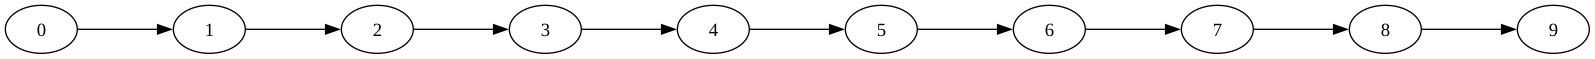

In [2]:
# L is the number of sites, also the length of the 1D spin chain
L = 10

# Generate the coupling map
edge_list = [(i - 1, i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges = edge_list[::2]
odd_edges = edge_list[1::2]
coupling_map = CouplingMap(edge_list)

# Generate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)
hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

# Generate a ZZ observable between the two middle qubits
observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

print("Hamiltonian:", hamiltonian)
print("Observable:", observable)
graphviz_draw(coupling_map.graph, method="circo")

With the Hamiltonian defined, we can proceed to construct the initial state.

In [3]:
# Generate an initial state
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

### Step 1: Map classical inputs to a quantum problem

Now that we have constructed the Hamiltonian, defining the spin-spin interactions and external magnetic fields that characterize the system, we follow three main steps in the AQC-Tensor workflow:

1. **Generate the optimized AQC circuit**: Using Trotterization, we approximate the initial evolution, which is then compressed to reduce circuit depth.
2. **Create the remaining time evolution circuit**: Capture the evolution for the remaining time beyond the initial segment.
3. **Combine the circuits**: Merge the optimized AQC circuit with the remaining evolution circuit into a complete time-evolution circuit ready for execution.

This approach creates a low-depth ansatz for the target evolution, supporting efficient simulation within near-term quantum hardware constraints.

#### Determine the portion of time evolution to simulate classically

Our goal is to simulate the time evolution of the model Hamiltonian defined earlier using Trotter evolution. To make this process efficient for quantum hardware, we split the evolution into two segments:

- **Initial Segment**: This initial portion of the evolution, from $ t_i = 0.0 $ to $ t_f = 0.2 $, is simulable with MPS and can be efficiently “compiled” using AQC-Tensor. By using the [AQC-Tensor Qiskit addon](https://github.com/Qiskit/qiskit-addon-aqc-tensor), we generate a compressed circuit for this segment, referred to as the `aqc_target_circuit`. Because this segment will be simulated on a tensor-network simulator, we can afford to use a higher number of Trotter layers without impacting hardware resources significantly. We set `aqc_target_num_trotter_steps = 32` for this segment.

- **Subsequent Segment**: This remaining portion of the evolution, from $ t = 0.2 $ to $ t = 0.4 $, will be executed on quantum hardware, referred to as the `subsequent_circuit`. Given hardware limitations, we aim to use as few Trotter layers as possible to maintain a manageable circuit depth. For this segment, we use `subsequent_num_trotter_steps = 3`.


#### Choose the split time
We choose $t = 0.2$ as the split time to balance classical simulability with hardware feasibility. Early in the evolution, entanglement in the XXZ model remains low enough for classical methods like MPS to approximate accurately.

When choosing a split time, a good guideline is to select a point where entanglement is still manageable classically but captures enough of the evolution to simplify the hardware-executed portion. Trial and error may be needed to find the best balance for different Hamiltonians.

In [4]:
# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

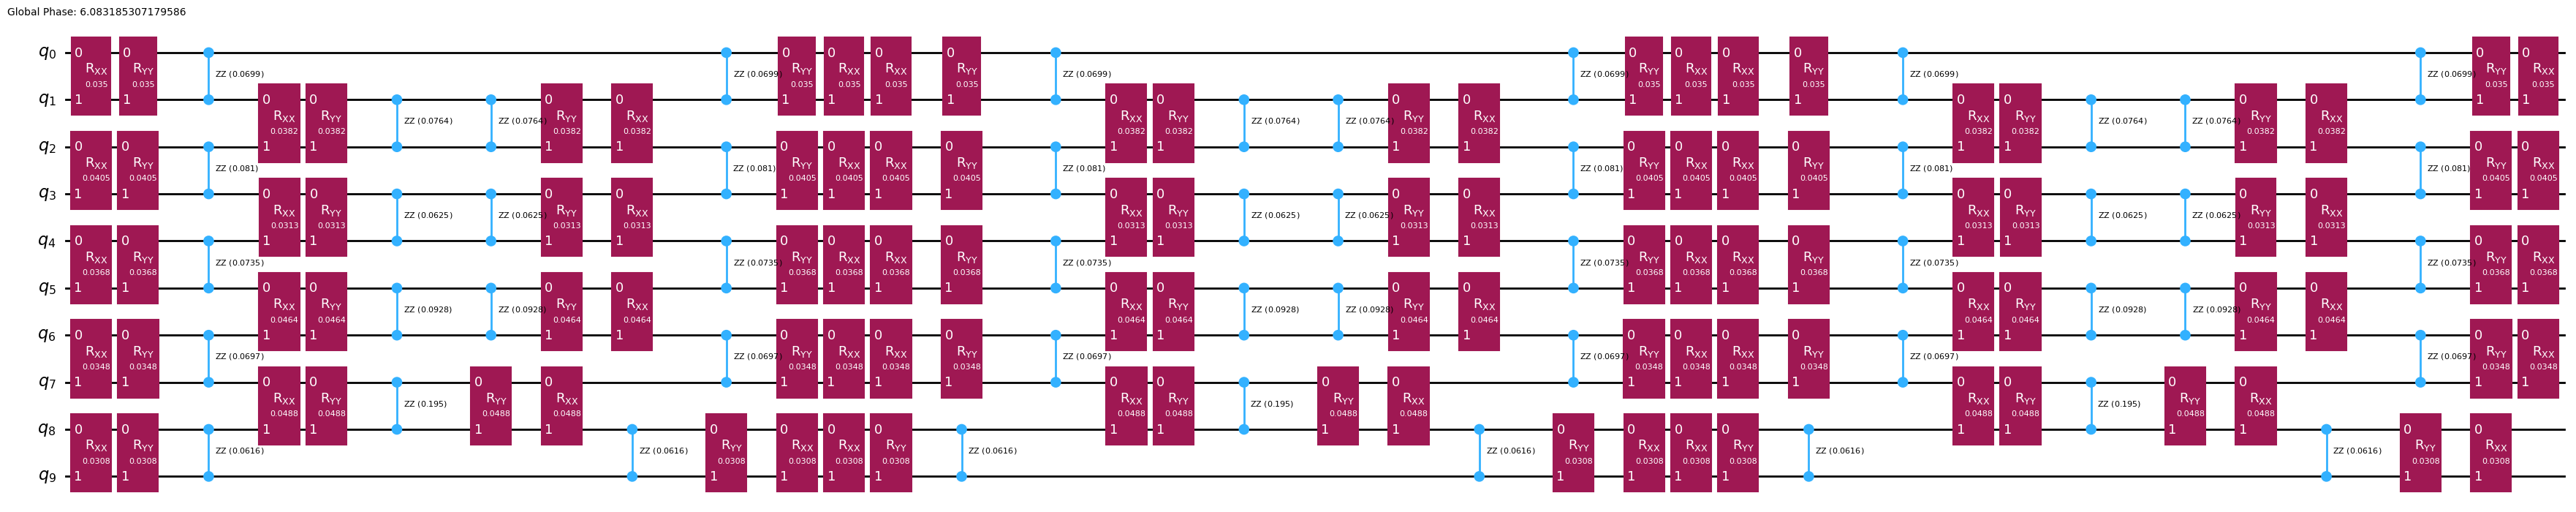

In [5]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
    time=subsequent_evolution_time,
)
subsequent_circuit.draw("mpl", fold=-1)

To enable a meaningful comparison, we will generate two additional circuits:

- **AQC comparison circuit**: This circuit evolves up to `aqc_evolution_time` but uses the same Trotter step duration as the `subsequent_circuit`. It serves as a comparison to the `aqc_target_circuit`, showing the evolution we would observe without using an increased number of Trotter steps. We will refer to this circuit as the `aqc_comparison_circuit`.

- **Reference circuit**: This circuit is used as a baseline to obtain the exact result. It simulates the full evolution using tensor networks to calculate the exact outcome, providing a reference for evaluating the effectiveness of AQC-Tensor. We will refer to this circuit as the `reference_circuit`.

In [6]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps
    / subsequent_evolution_time
    * aqc_evolution_time
)
print(
    "Number of Trotter steps for comparison:",
    aqc_comparison_num_trotter_steps,
)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


In [7]:
# Generate the reference circuit
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

#### Generate an ansatz and initial parameters from a Trotter circuit with fewer steps

Now that we have constructed our four circuits, let's proceed with the AQC-Tensor workflow. First, we construct a “good” circuit that has the same evolution time as the target circuit, but with fewer Trotter steps (and thus fewer layers).

Then we pass this “good” circuit to AQC-Tensor’s `generate_ansatz_from_circuit` function. This function analyzes the two-qubit connectivity of the circuit and returns two things:

1. A general, parametrized ansatz circuit with the same two-qubit connectivity as the input circuit.
2. Parameters that, when plugged into the ansatz, yield the input (good) circuit.

Soon we will take these parameters and iteratively adjust them to bring the ansatz circuit as close as possible to the target MPS.

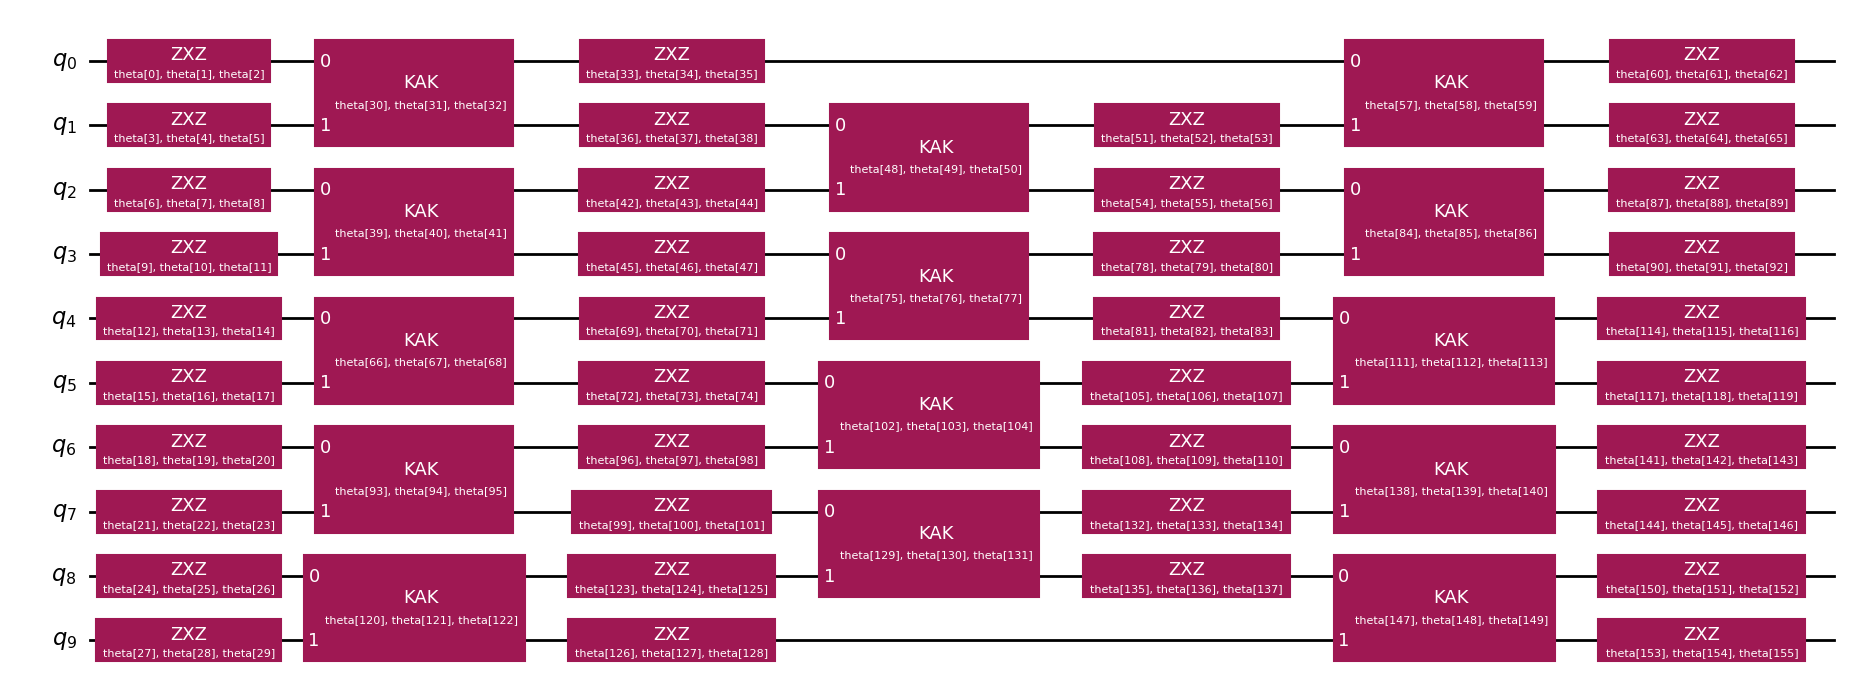

In [8]:
aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit
)
aqc_ansatz.draw("mpl", fold=-1)

In [9]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(
    f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters"
)

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 156 parameters


#### Choose settings for tensor network simulation

Here, we use Quimb's matrix-product state circuit simulator, along with jax to provide the gradient.

In [10]:
simulator_settings = QuimbSimulator(
    quimb.tensor.CircuitMPS, autodiff_backend="jax"
)

Next, we build a MPS representation of the target state that will be approximated using AQC-Tensor. This representation enables efficient handling of entanglement, providing a compact description of the quantum state for further optimization.

In [11]:
aqc_target_mps = tensornetwork_from_circuit(
    aqc_target_circuit, simulator_settings
)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examining the `local_expectation``
reference_mps = tensornetwork_from_circuit(
    reference_circuit, simulator_settings
)
reference_expval = reference_mps.local_expectation(
    quimb.pauli("Z") & quimb.pauli("Z"), (L // 2 - 1, L // 2)
).real.item()
print("Reference MPS maximum bond dimension:", reference_mps.psi.max_bond())

Target MPS maximum bond dimension: 5
Reference MPS maximum bond dimension: 7


Note that, by choosing a larger number of Trotter steps for the target state, we have effectively reduced its Trotter error compared to the initial circuit. We can evaluate the fidelity ($ |\langle \psi_1 | \psi_2 \rangle|^2 $) between the state prepared by the initial circuit and the target state to quantify this difference.

In [12]:
good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Starting fidelity: 0.9982464959067222


#### Optimize the parameters of the ansatz using MPS calculations
In this step, we optimize the ansatz parameters by minimizing a simple cost function, `MaximizeStateFidelity`, using the L-BFGS optimizer from SciPy. We select a stopping criterion for the fidelity that ensures it surpasses the fidelity of the initial circuit without AQC-Tensor. Once this threshold is reached, the compressed circuit will exhibit both lower Trotter error and reduced depth compared to the original circuit. By using additional CPU time, further optimization can continue to increase fidelity.

In [29]:
# Setting values for the optimization
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = MaximizeStateFidelity(
    aqc_target_mps, aqc_ansatz, simulator_settings
)


def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(
        f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}"
    )
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if (
    result.status
    not in (
        0,
        1,
        99,
    )
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

2025-04-14 11:46:52.174235 Intermediate result: Fidelity 0.99795851
2025-04-14 11:46:52.218249 Intermediate result: Fidelity 0.99822826
2025-04-14 11:46:52.280924 Intermediate result: Fidelity 0.99829675
2025-04-14 11:46:52.356214 Intermediate result: Fidelity 0.99832474
2025-04-14 11:46:52.411609 Intermediate result: Fidelity 0.99836131
2025-04-14 11:46:52.453747 Intermediate result: Fidelity 0.99839954
2025-04-14 11:46:52.496184 Intermediate result: Fidelity 0.99846517
2025-04-14 11:46:52.542046 Intermediate result: Fidelity 0.99865029
2025-04-14 11:46:52.583679 Intermediate result: Fidelity 0.99872332
2025-04-14 11:46:52.628732 Intermediate result: Fidelity 0.99892359
2025-04-14 11:46:52.690386 Intermediate result: Fidelity 0.99900640
2025-04-14 11:46:52.759398 Intermediate result: Fidelity 0.99907169
2025-04-14 11:46:52.819496 Intermediate result: Fidelity 0.99911423
2025-04-14 11:46:52.884505 Intermediate result: Fidelity 0.99918716
2025-04-14 11:46:52.947919 Intermediate result: 

In [14]:
parameters = [float(param) for param in aqc_final_parameters]
print("Final parameters:", parameters)

Final parameters: [-7.853983035039254, 1.5707966468427772, 1.5707962768868613, -1.570798010835122, 1.570794480409574, 1.5707972214146968, -1.570796593027083, 1.5707968206822998, -1.5707959018046258, -1.5707991700969144, 1.5707965852600927, 4.712386891737442, -7.853980840717957, 1.5707967508132654, 1.5707943162503217, -1.5707955382023582, 1.5707958007156742, 1.570796096113293, -1.5707928509846847, 1.5707971042943747, -1.570797909276557, -1.5707941020637393, 1.5707980179540793, 4.712389823219363, -1.5707928752386107, 1.5707996426312891, -1.5707975640471001, -1.570794132802984, 1.5707944361599957, 4.712390747060803, 0.1048818190315936, 0.06686710468840577, -0.0668645844756557, -3.1415923537135466, 1.2374931269696063, 6.323169390432535e-07, 3.53229204771738e-08, 2.1091105688681484, 6.283186439944202, 0.12152258846156239, 0.07961752617254866, -0.07961775088604585, -1.6564278051174865e-06, 2.0771163596472384, 3.141592651630471, -6.283185775192653, 1.7691609006726954, 3.1415922910116216, 0.19

At this point, it is only necessary to find the final parameters to the ansatz circuit. We can then merge the optimized AQC circuit with the remaining evolution circuit to create a complete time-evolution circuit for execution on quantum hardware.

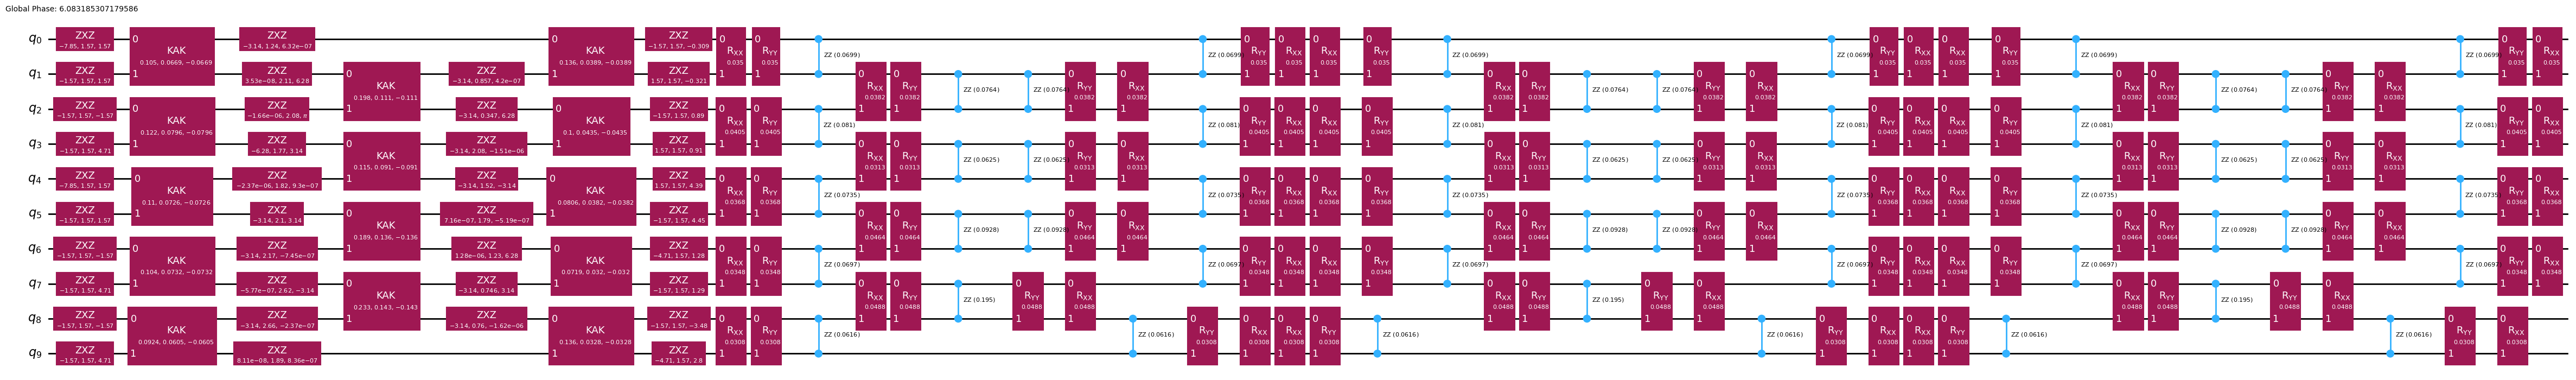

In [15]:
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)
aqc_final_circuit.draw("mpl", fold=-1)

We also need to merge our `aqc_comparison_circuit` with the remaining evolution circuit. This circuit will be used to compare the performance of the AQC-Tensor-optimized circuit with the original circuit.

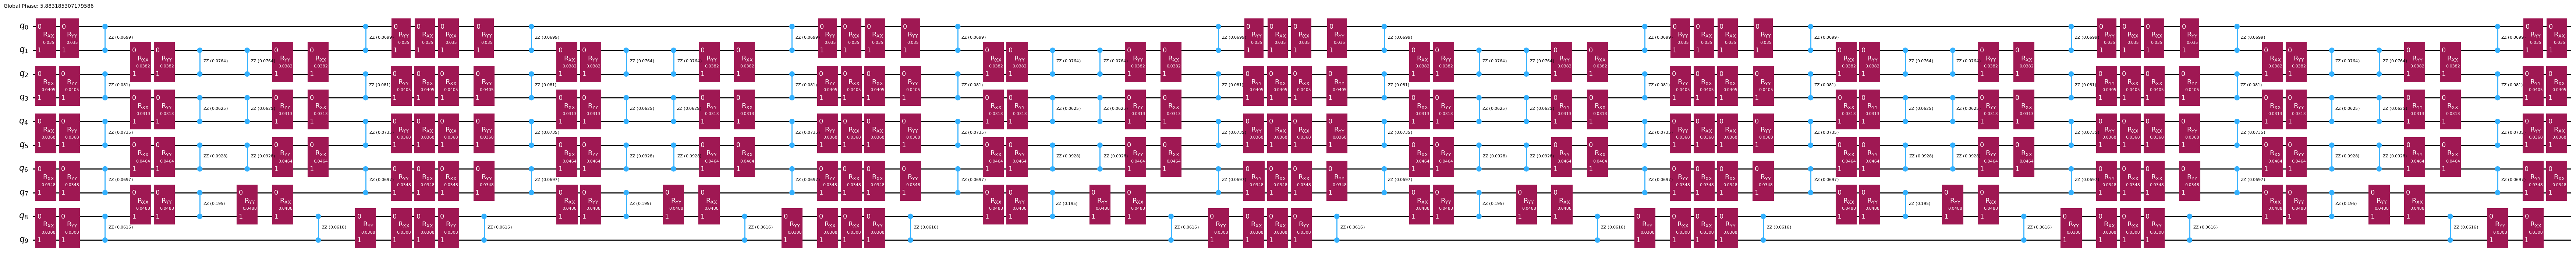

In [16]:
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

### Step 2: Optimize problem for quantum hardware execution

Select the hardware. Here we will use any of the IBM Quantum&reg; devices available that have at least 127 qubits.

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)
print(backend)

We transpile PUBs (circuit and observables) to match the backend ISA (Instruction Set Architecture). By setting `optimization_level=3`, the transpiler optimizes the circuit to fit a one-dimensional chain of qubits, reducing the noise that impacts circuit fidelity. Once the circuits are transformed into a format compatible with the backend, we apply a corresponding transformation to the observables to ensure they align with the modified qubit layout.

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 111


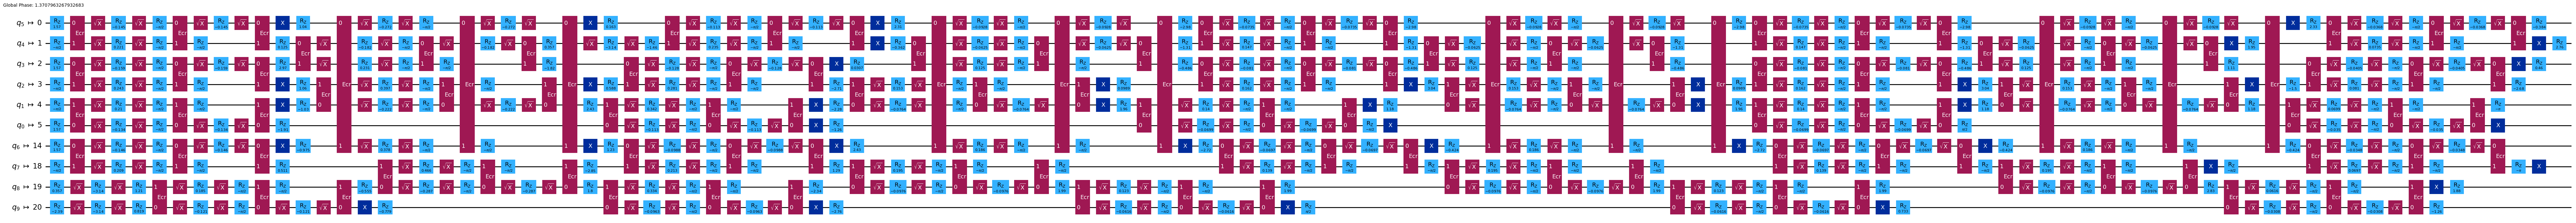

In [18]:
pass_manager = generate_preset_pass_manager(
    backend=backend, optimization_level=3
)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Perform transpilation for the comparison circuit.

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 158


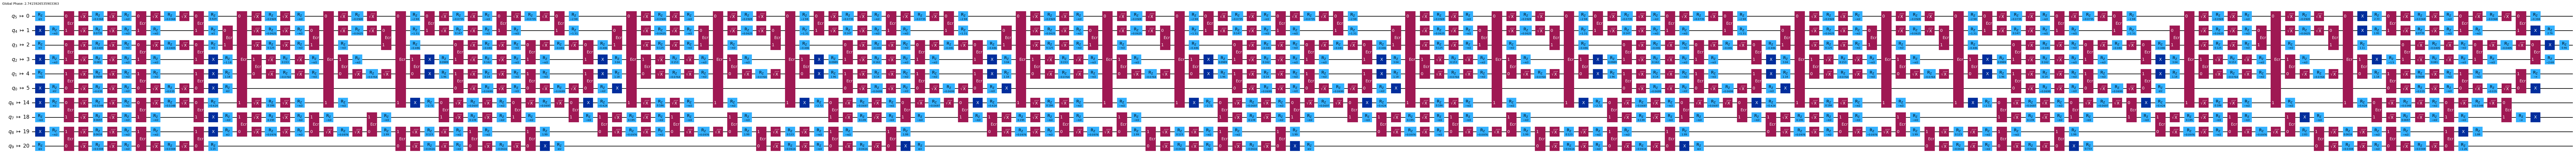

In [19]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(
    isa_comparison_circuit.layout
)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

### Step 3: Execute using Qiskit primitives

In this step, we execute the transpiled circuit on quantum hardware (or a simulated backend). Using the `EstimatorV2` class from `qiskit_ibm_runtime`, we set up an estimator to run the circuit and measure the specified observable. The job result provides the expected outcome for the observable, giving us insights into the circuit’s performance on the target hardware.

In [20]:
estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: czyhqdxd8drg008hx0yg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

Perform the execution for the comparison circuit.

In [21]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: czyhqdxd8drg008hx0yg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

### Step 4: Post-process and return result in desired classical format

In this case, reconstruction is unnecessary. We can directly examine the result by accessing the expectation value from the execution output.

In [22]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [
    pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts
]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [
    pub_result.data.__dict__ for pub_result in hw_comparison_results
]
hw_comparison_expvals = [
    pub_result_data["evs"].tolist()
    for pub_result_data in hw_comparison_results_dicts
]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(
    f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}"
)
print(
    f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}"
)

Exact:         	-0.5252
AQC:           	-0.4903, |∆| = 0.0349
AQC Comparison:	0.5424, |∆| = 1.0676


Bar plot to compare the results of the AQC, comparison, and exact circuits.

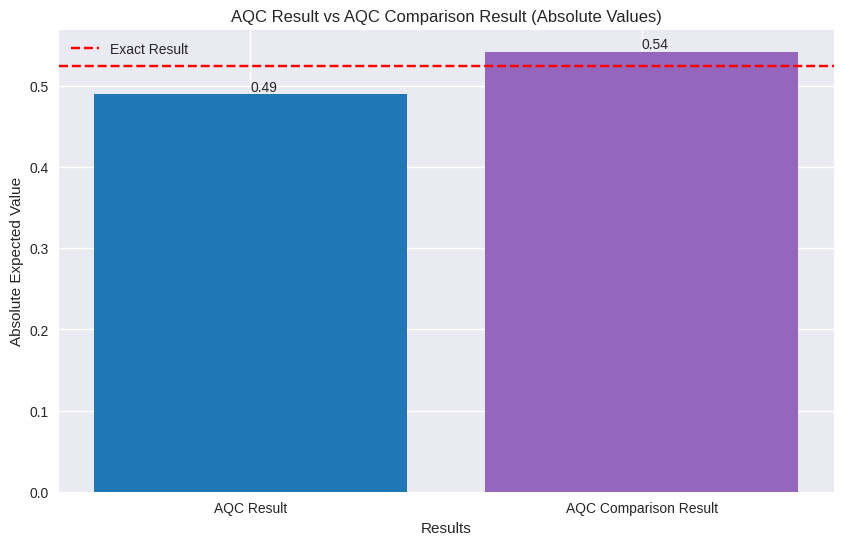

In [23]:
plt.style.use("seaborn-v0_8")

labels = ["AQC Result", "AQC Comparison Result"]
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=["tab:blue", "tab:purple"])
plt.axhline(
    y=abs(reference_expval), color="red", linestyle="--", label="Exact Result"
)
plt.xlabel("Results")
plt.ylabel("Absolute Expected Value")
plt.title("AQC Result vs AQC Comparison Result (Absolute Values)")
plt.legend()
for bar in bars:
    y_val = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        y_val,
        round(y_val, 2),
        va="bottom",
    )
plt.show()

## Part II: scale it up


The second part of this tutorial builds on the previous example by scaling up to a larger system with 50 sites, illustrating how to map more complex quantum simulation problems to executable quantum circuits. Here, we explore the dynamics of a 50-site XXZ model, allowing us to build and optimize a substantial quantum circuit that reflects more realistic system sizes.

The Hamiltonian for our 50-site XXZ model is defined as:
$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

where $J_{i,(i+1)}$ is a random coefficient corresponding to edge $(i, i+1)$, and $L=50$ is the number of sites.

Define the coupling map and edges for the Hamiltonian.

In [30]:
L = 50  # L = length of our 1D spin chain

# Generate the edge list for this spin-chain
edge_list = [(i - 1, i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges = edge_list[::2]
odd_edges = edge_list[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(edge_list)

# Generate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)

hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

# Generate an initial state
L = hamiltonian.num_qubits
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

### Step 1: Map classical inputs to a quantum problem

For this larger problem, we start by constructing the Hamiltonian for the 50-site XXZ model, defining spin-spin interactions and external magnetic fields across all sites. After this, we follow three main steps:

1. **Generate the optimized AQC circuit**: Use Trotterization to approximate the initial evolution, then compress this segment to reduce circuit depth.
2. **Create the remaining time evolution circuit**: Capture the remaining time evolution beyond the initial segment.
3. **Combine the circuits**: Merge the optimized AQC circuit with the remaining evolution circuit to create a complete time-evolution circuit ready for execution.

Generate the AQC target circuit (the initial segment).

In [31]:
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

Generate the subsequent circuit (the remaining segment).

In [32]:
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
    time=subsequent_evolution_time,
)

Generate the AQC comparison circuit (the initial segment, but with the same number of Trotter steps as the subsequent circuit).

In [33]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps
    / subsequent_evolution_time
    * aqc_evolution_time
)
print(
    "Number of Trotter steps for comparison:",
    aqc_comparison_num_trotter_steps,
)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


Generate the reference circuit.

In [34]:
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

Generate an ansatz and initial parameters from a Trotter circuit with fewer steps.

In [35]:
aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit
)

In [36]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(
    f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters"
)

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 816 parameters


Set settings for tensor network simulation and then construct a matrix product state representation of the target state for optimization. Then, evaluate the fidelity between the initial circuit and the target state to quantify the difference in Trotter error.

In [37]:
simulator_settings = QuimbSimulator(
    quimb.tensor.CircuitMPS, autodiff_backend="jax"
)

# Build the matrix-product representation of the state to be approximated by AQC
aqc_target_mps = tensornetwork_from_circuit(
    aqc_target_circuit, simulator_settings
)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examining the `local_expectation``
reference_mps = tensornetwork_from_circuit(
    reference_circuit, simulator_settings
)
reference_expval = reference_mps.local_expectation(
    quimb.pauli("Z") & quimb.pauli("Z"), (L // 2 - 1, L // 2)
).real.item()

# Compute the starting fidelity
good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Target MPS maximum bond dimension: 5
Starting fidelity: 0.9926466919924161


To optimize the ansatz parameters, we minimize the `MaximizeStateFidelity` cost function using the L-BFGS optimizer from SciPy, with a stopping criterion set to surpass the fidelity of the initial circuit without AQC-Tensor. This ensures that the compressed circuit has both lower Trotter error and reduced depth.

In [38]:
# Setting values for the optimization
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = MaximizeStateFidelity(
    aqc_target_mps, aqc_ansatz, simulator_settings
)


def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(
        f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}"
    )
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if (
    result.status
    not in (
        0,
        1,
        99,
    )
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

2025-04-14 11:48:28.705807 Intermediate result: Fidelity 0.99795851
2025-04-14 11:48:28.743265 Intermediate result: Fidelity 0.99822826
2025-04-14 11:48:28.776629 Intermediate result: Fidelity 0.99829675
2025-04-14 11:48:28.816153 Intermediate result: Fidelity 0.99832474
2025-04-14 11:48:28.856437 Intermediate result: Fidelity 0.99836131
2025-04-14 11:48:28.896432 Intermediate result: Fidelity 0.99839954
2025-04-14 11:48:28.936670 Intermediate result: Fidelity 0.99846517
2025-04-14 11:48:28.982069 Intermediate result: Fidelity 0.99865029
2025-04-14 11:48:29.026130 Intermediate result: Fidelity 0.99872332
2025-04-14 11:48:29.067426 Intermediate result: Fidelity 0.99892359
2025-04-14 11:48:29.110742 Intermediate result: Fidelity 0.99900640
2025-04-14 11:48:29.161362 Intermediate result: Fidelity 0.99907169
2025-04-14 11:48:29.207933 Intermediate result: Fidelity 0.99911423
2025-04-14 11:48:29.266772 Intermediate result: Fidelity 0.99918716
2025-04-14 11:48:29.331727 Intermediate result: 

In [39]:
parameters = [float(param) for param in aqc_final_parameters]

Construct the final circuit for transpilation by assembling the optimized ansatz with the remaining time evolution circuit.

In [40]:
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)

In [41]:
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)

### Step 2: Optimize problem for quantum hardware execution

Select the backend.

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)
print(backend)

Transpile the completed circuit on the target hardware, preparing it for execution. The resulting ISA circuit can then be sent for execution on the backend.

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 122


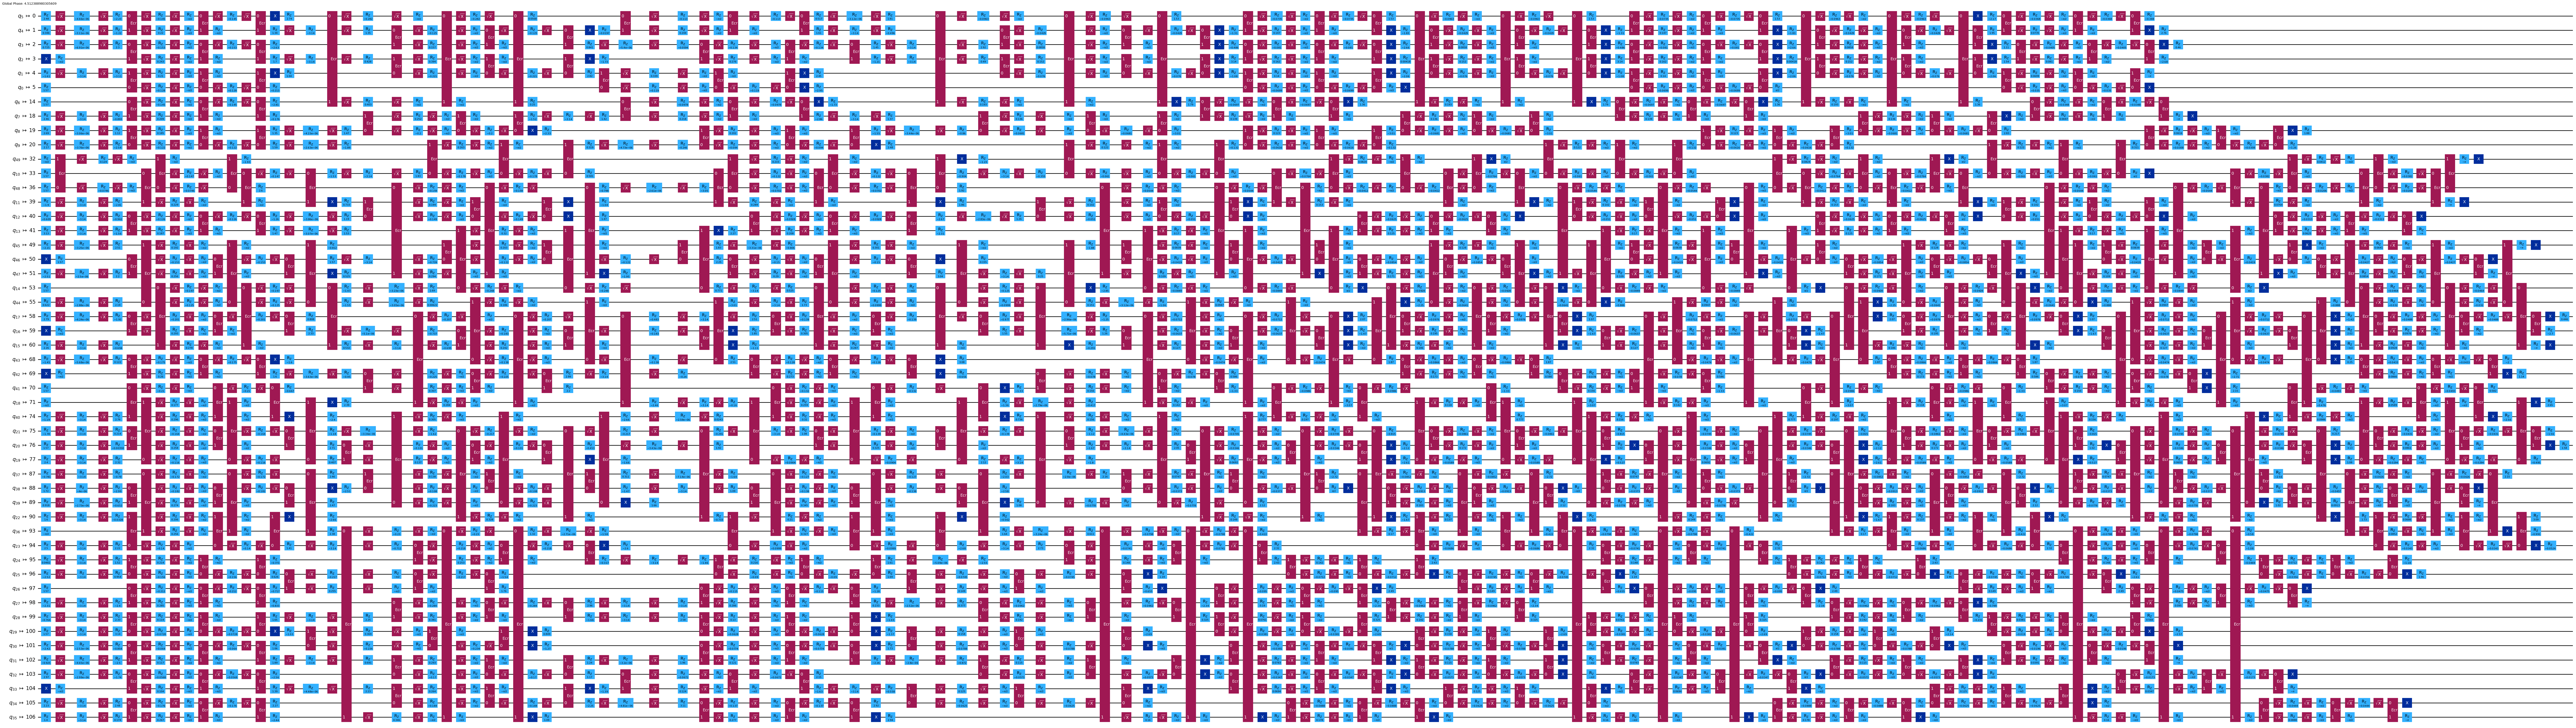

In [43]:
pass_manager = generate_preset_pass_manager(
    backend=backend, optimization_level=3
)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 158


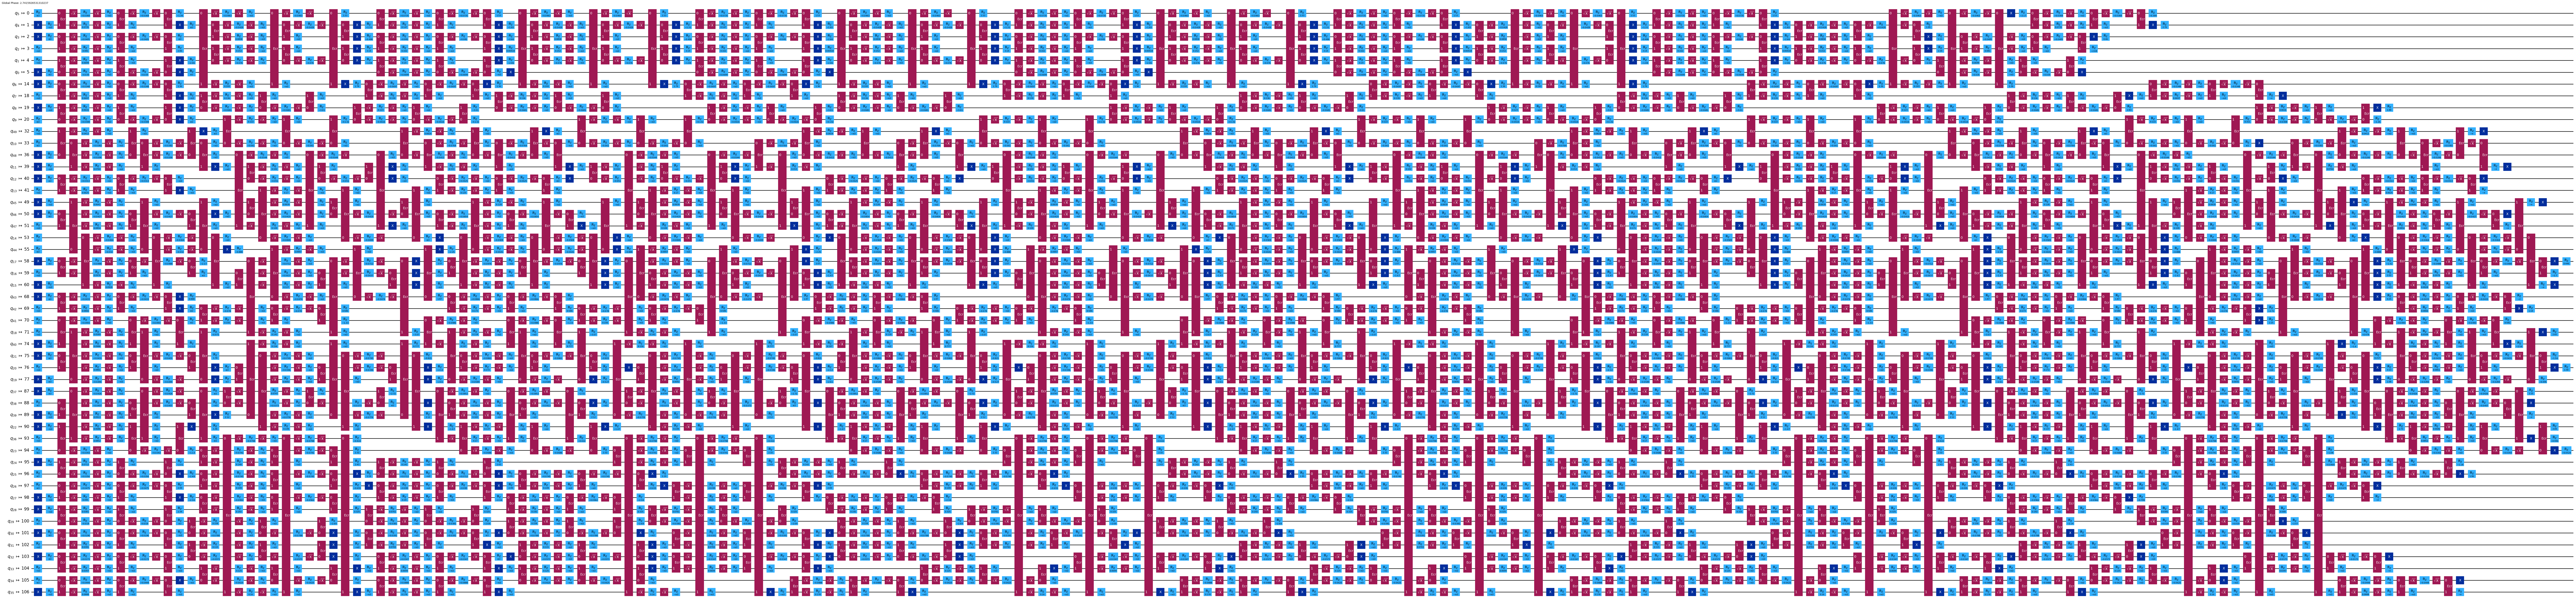

In [44]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(
    isa_comparison_circuit.layout
)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

### Step 3: Execute using Qiskit primitives

In this step, we run the transpiled circuit on quantum hardware (or a simulated backend) using `EstimatorV2` from `qiskit_ibm_runtime` to measure the specified observable. The job result will provide valuable insights into the circuit’s performance on the target hardware.

For this larger-scale example, we will explore how to utilize `EstimatorOptions` to better manage and control the parameters of our hardware experiment. While these settings are optional, they are useful for tracking experiment parameters and refining execution options for optimal results.

For a complete list of available execution options, refer to the [qiskit-ibm-runtime documentation](/docs/api/qiskit-ibm-runtime/options-estimator-options).

In [45]:
twirling_options = {
    "enable_gates": True,
    "enable_measure": True,
    "num_randomizations": 300,
    "shots_per_randomization": 100,
    "strategy": "active",
}

zne_options = {
    "amplifier": "gate_folding",
    "noise_factors": [1, 2, 3],
    "extrapolated_noise_factors": list(np.linspace(0, 3, 31)),
    "extrapolator": ["exponential", "linear", "fallback"],
}

meas_learning_options = {
    "num_randomizations": 512,
    "shots_per_randomization": 512,
}

resilience_options = {
    "measure_mitigation": True,
    "zne_mitigation": True,
    "zne": zne_options,
    "measure_noise_learning": meas_learning_options,
}

estimator_options = {
    "resilience": resilience_options,
    "twirling": twirling_options,
}

estimator = Estimator(backend, options=estimator_options)

In [46]:
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: czyjx6crxz8g008f63r0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

In [47]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: czyjx6crxz8g008f63r0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

### Step 4: Post-process and return result in desired classical format
Here, no reconstruction is needed, like before; we can directly access the expectation value from the execution output to examine the result.

In [48]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [
    pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts
]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [
    pub_result.data.__dict__ for pub_result in hw_comparison_results
]
hw_comparison_expvals = [
    pub_result_data["evs"].tolist()
    for pub_result_data in hw_comparison_results_dicts
]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(
    f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}"
)
print(
    f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}"
)

Exact:         	-0.5888
AQC:           	-0.4809, |∆| = 0.1078
AQC Comparison:	1.1764, |∆| = 1.7652


Plot the results of the AQC, comparison, and exact circuits for the 50-site XXZ model.

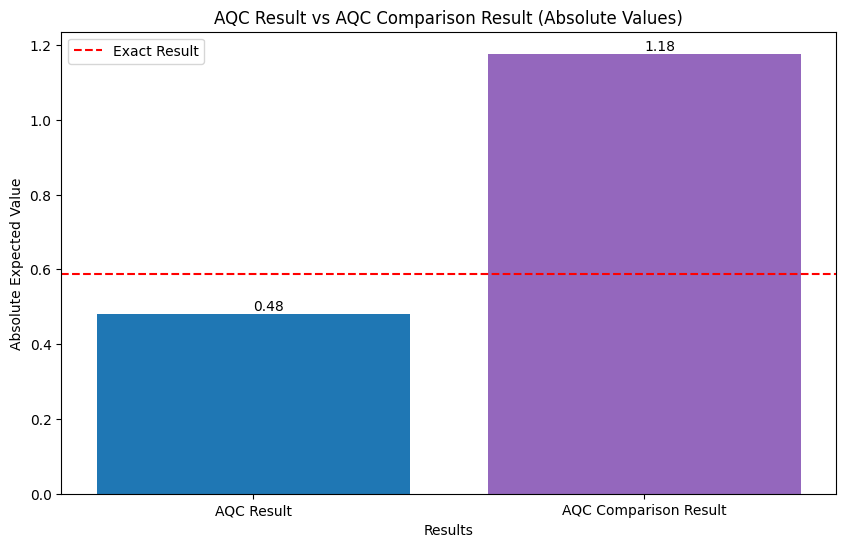

In [49]:
labels = ["AQC Result", "AQC Comparison Result"]
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=["tab:blue", "tab:purple"])
plt.axhline(
    y=abs(reference_expval), color="red", linestyle="--", label="Exact Result"
)
plt.xlabel("Results")
plt.ylabel("Absolute Expected Value")
plt.title("AQC Result vs AQC Comparison Result (Absolute Values)")
plt.legend()
for bar in bars:
    y_val = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        y_val,
        round(y_val, 2),
        va="bottom",
    )

plt.show()

## Conclusion

This tutorial demonstrated how to use Approximate Quantum Compilation with tensor networks (AQC-Tensor) to compress and optimize circuits for simulating quantum dynamics at scale. Utilizing both small and large Heisenberg models, we applied AQC-Tensor to reduce the circuit depth required for Trotterized time evolution. By generating a parametrized ansatz from a simplified Trotter circuit and optimizing it with matrix product state (MPS) techniques, we achieved a low-depth approximation of the target evolution that is both accurate and efficient.

The workflow here highlights the key advantages of AQC-Tensor for scaling quantum simulations:

- **Significant circuit compression**: AQC-Tensor reduced the circuit depth needed for complex time evolution, enhancing its feasibility on current devices.
- **Efficient optimization**: The MPS approach provided a robust framework for parameter optimization, balancing fidelity with computational efficiency.
- **Hardware-ready execution**: Transpiling the final optimized circuit ensured it met the constraints of the target quantum hardware.

As larger quantum devices and more advanced algorithms emerge, techniques like AQC-Tensor will become essential for running complex quantum simulations on near-term hardware, demonstrating promising progress in managing depth and fidelity for scalable quantum applications.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_eF01c2sfeSt6cqq)

© IBM Corp. 2025